<h1><center>Twitter US Airline Sentiment</center></h1>

# Background and Context

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

# Objective

Determine the sentiments of tweets and help brands to act accordingly.

# Data Dictionary 

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").


The dataset has the following columns:

* tweet_id                                                           
* airline_sentiment                                               
* airline_sentiment_confidence                               
* negativereason                                                   
* negativereason_confidence                                    
* airline                                                                    
* airline_sentiment_gold                                              
* name     
* negativereason_gold 
* retweet_count
* text
* tweet_coord
* tweet_created
* tweet_location 
* user_timezone

# Let's start coding!

### Loading necessary libraries

In [1]:
# install and import necessary libraries.

#!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
import matplotlib.pyplot as plt


# to split the data into test and train set
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import CountVectorizer  # Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  # Vectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier          # Random forest Classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, classification_report,confusion_matrix

%matplotlib inline
import seaborn as sns
sns.set()

import warnings                                         # Import warning pacakge  
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
from wordcloud import WordCloud,STOPWORDS               # Import of word clound 

[nltk_data] Downloading package stopwords to /Users/tkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tkhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load the data for analysis

In [2]:
data=pd.read_csv('tweets.csv')
df = data.copy()

### Shape of the data

In [3]:
print("There are "+ str(df.shape[0]) +" rows and "+ str(df.shape[1])+" columns") 

There are 14640 rows and 15 columns


### Let's view a sample of the dataset.

In [4]:
np.random.seed(2)  # To get the same random results every time
df.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
8917,567750136223518720,positive,1.0000,NaN,NaN,Delta,NaN,amyfame,NaN,0,@JetBlue Thank you!,NaN,2015-02-17 10:19:15 -0800,NaN,Eastern Time (US & Canada)
9534,569888646633017344,negative,1.0000,Late Flight,1.0000,US Airways,NaN,Tasil2005,NaN,0,@USAirways What is going on with flight 1826 f...,NaN,2015-02-23 07:56:56 -0800,NaN,NaN
12875,569993908324663296,neutral,0.6654,NaN,NaN,American,NaN,kiasuchick,NaN,0,"@AmericanAir Yes, thanks I found those, didn't...",NaN,2015-02-23 14:55:12 -0800,"Los Angeles, CA",Pacific Time (US & Canada)
4601,569988842335244289,positive,1.0000,NaN,NaN,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir Big kudos to your staff today at...,NaN,2015-02-23 14:35:04 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)
4308,567714192980201472,negative,1.0000,longlines,0.3469,United,NaN,lauralscott,NaN,0,@united last night we waited forever at the ga...,"[0.0, 0.0]",2015-02-17 07:56:25 -0800,"ÜT: 40.976702,-72.210688",Quito


### Duplicate values in the data

In [5]:
df.duplicated().sum()

36

### Missing values (count) in the data.

In [6]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

### Unique values (count) in the data.

In [7]:
df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

### Data types of the columns in the dataset.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

### Summary of the dataset

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


**Observation**
* There are 14640 rows with 15 columns in the dataset.
* 36 records are duplicate.

# Exploratory Data Analysis and Visualization

#### Reusable methods

In [10]:
# Draws Count plot
def drawCountPlot(columnName,axes,df):
    dataPoints=df[columnName]
    indexCount = dataPoints.value_counts().index
    ax = sns.countplot(dataPoints, order=indexCount ,ax=axes)
    for patch in ax.patches:
        percentage = 100 * (patch.get_height()*1.0)/dataPoints.count()
        x = patch.get_x() + patch.get_width() / 2 - 0.05 
        y = patch.get_y() + patch.get_height()
        ax.annotate("{percent:.2f}".format(percent=percentage)+"%", (x, y))

### Distribution of sentiment across all the tweets.

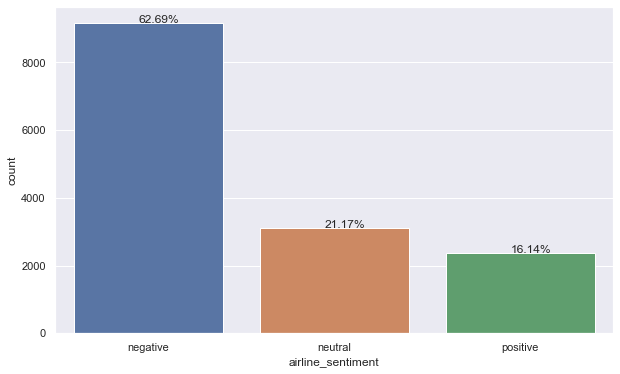

In [11]:
fig, axes = plt.subplots(ncols=1,figsize=(10, 6))
drawCountPlot('airline_sentiment',axes,df)

**Observation**
* 62.69% of tweets were negative in nature
* 21.17% of tweets were neutral in nature
* 16.14% of tweets were only positive in nature

### Distribution of all tweets among each airline

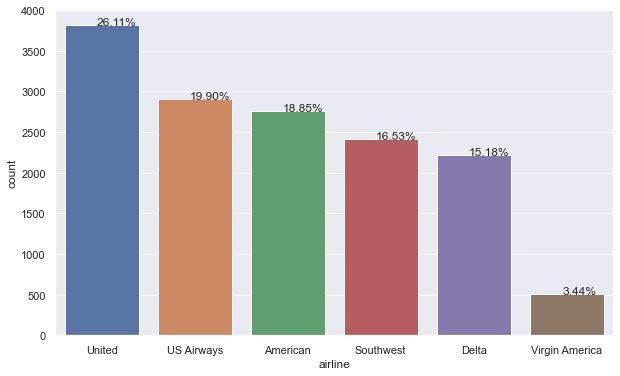

In [12]:
fig, axes = plt.subplots(ncols=1,figsize=(10, 6))
drawCountPlot('airline',axes,df)

**Observation**
* Maximum number of tweets is for United (26.11%), followed by US Airways(19.90%) and then American(18.85%)
* Virgin America (3.44%) has least number of tweets.

### Distribution of Sentiment of tweets for each airline

<Figure size 864x864 with 0 Axes>

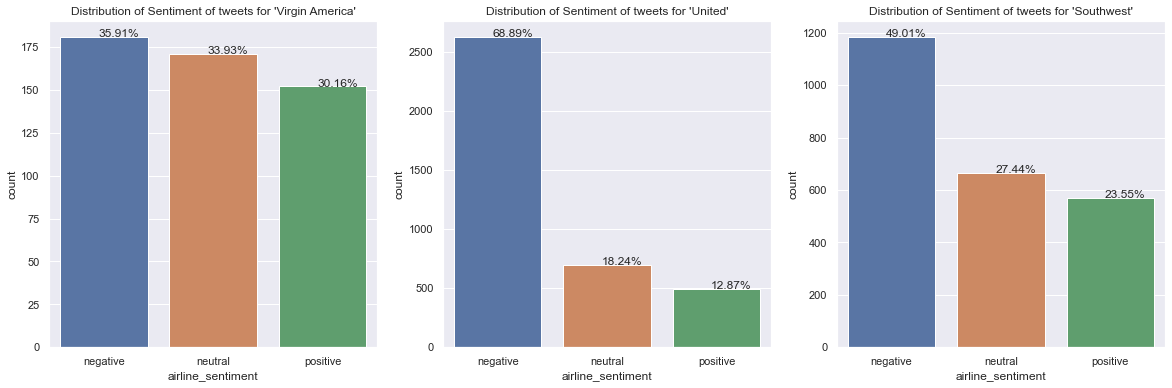

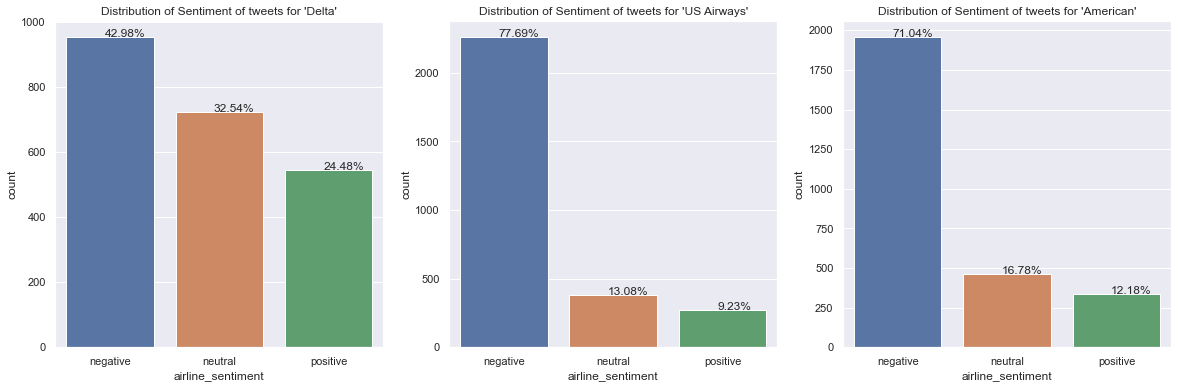

In [13]:
airlines=df.airline.unique()
plt.figure(1,figsize=(12, 12))

i=0

# run the loop too total airlines/ 3 times, so that on each row we plot 3 airlines graph
while  i< airlines.size/3:
    fig, axes = plt.subplots(ncols=3,figsize=(20, 6))
    j=0;
    while j<3:
        # create dataframe for each airline
        airline_df=df[df['airline']==airlines[i*3+j]]
        
        #plot the distribution of airline_sentiment for a particular airline
        axes[j].set_title("Distribution of Sentiment of tweets for '"+ airlines[i*3+j]+"'")
        drawCountPlot('airline_sentiment',axes[j],airline_df) 
        j=j+1
    i=i+1    

**Observation**
* Total percentage of tweets for United was 26.11% out of which negative (68.89%), positive (12.87%) and neutral (18.24%) are tweets.
* Total percentage of tweets for US Airways was 19.90% out of which negative (77.69%), positive (9.23%) and neutral (13.08%) are tweets.
* Total percentage of tweets for American was 18.85% out of which negative (71.04%), positive (12.18%) and neutral (16.78%) are tweets.
* Total percentage of tweets for Southwest was 16.53% out of which negative (49.01%), positive (23.55%) and neutral (27.44%) are tweets.
* Total percentage of tweets for Delta was 15.18% out of which negative (42.98%), positive (24.48%) and neutral (32.54%) are tweets.
* Total percentage of tweets for Virgin America was 3.44% out of which negative (35.91%), positive (30.16%) and neutral (33.93%) are tweets.

* Tweets for Virgin America is balanced in nature in terms of sentiments
* Highest percentage of negative tweets is for US Airways (71.04%), followed by American (71.69%), United (68.89%)

### Distribution of all the negative reasons

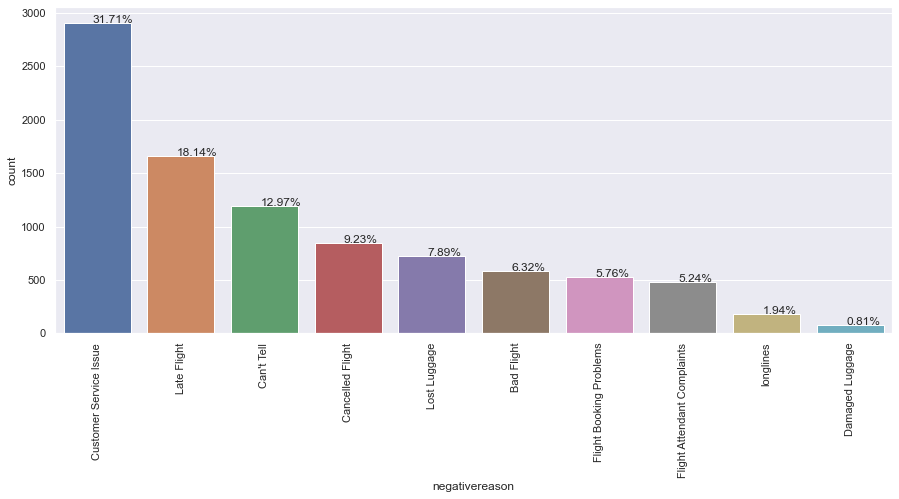

In [14]:
fig, axes = plt.subplots(ncols=1,figsize=(15, 6))

plt.xticks(rotation=90)
drawCountPlot('negativereason',axes,df)

**Observation**
* Customer Service Issue (31.71%) is the top reason for negative tweets, followed by Late Flight, Can't Tell (12.97%), Cancelled Flight (9.23%), lost Luggage(7.89%)
* Damaged Luggage (0.81) was the reason for negative tweets

### Distribution of all the Negative reasons for each airline

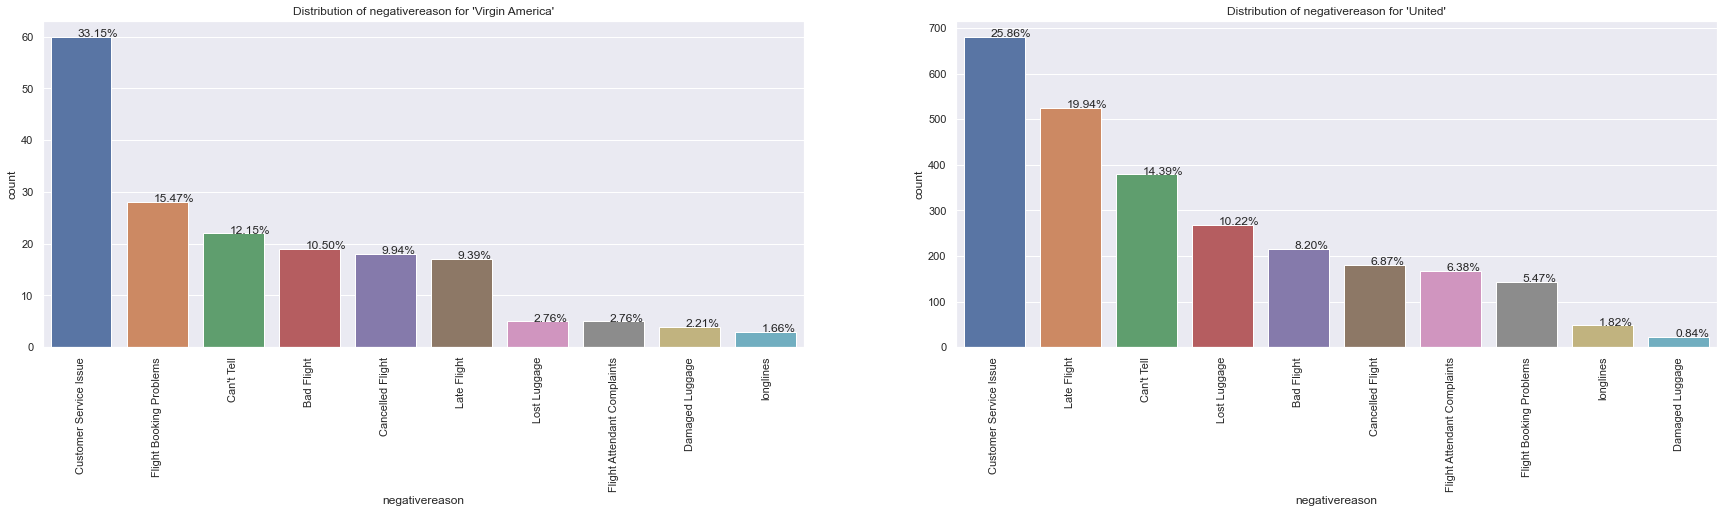

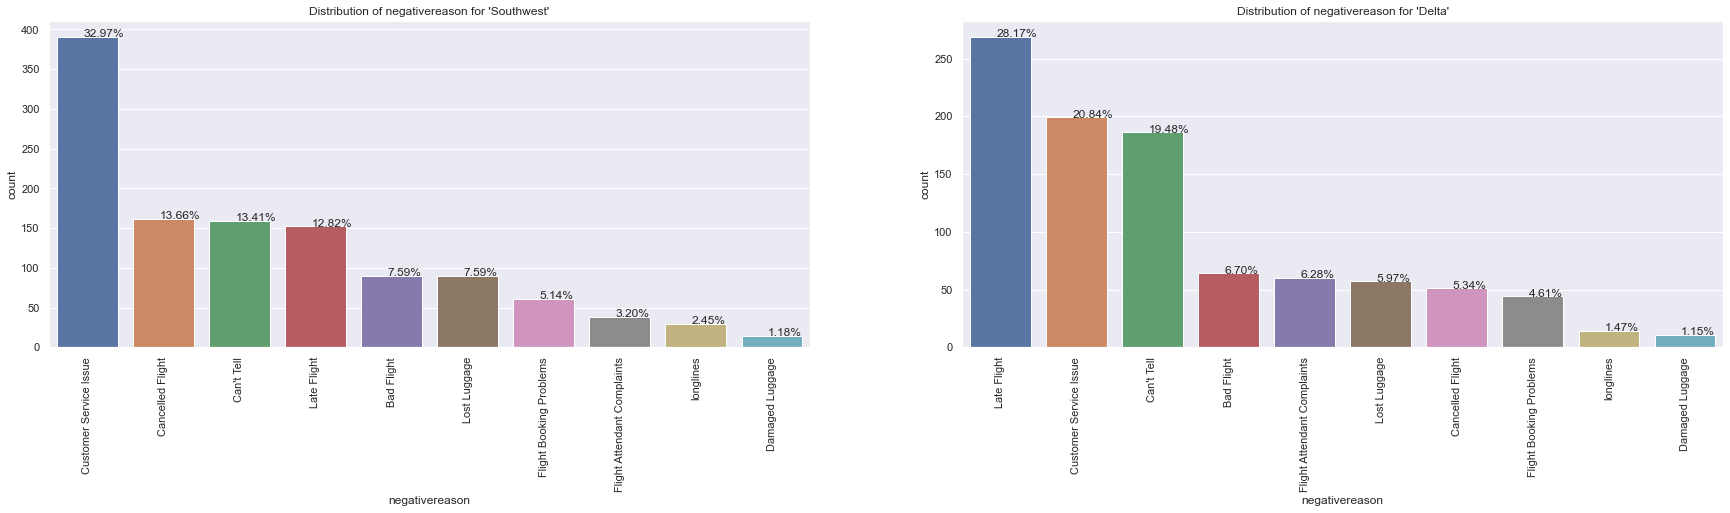

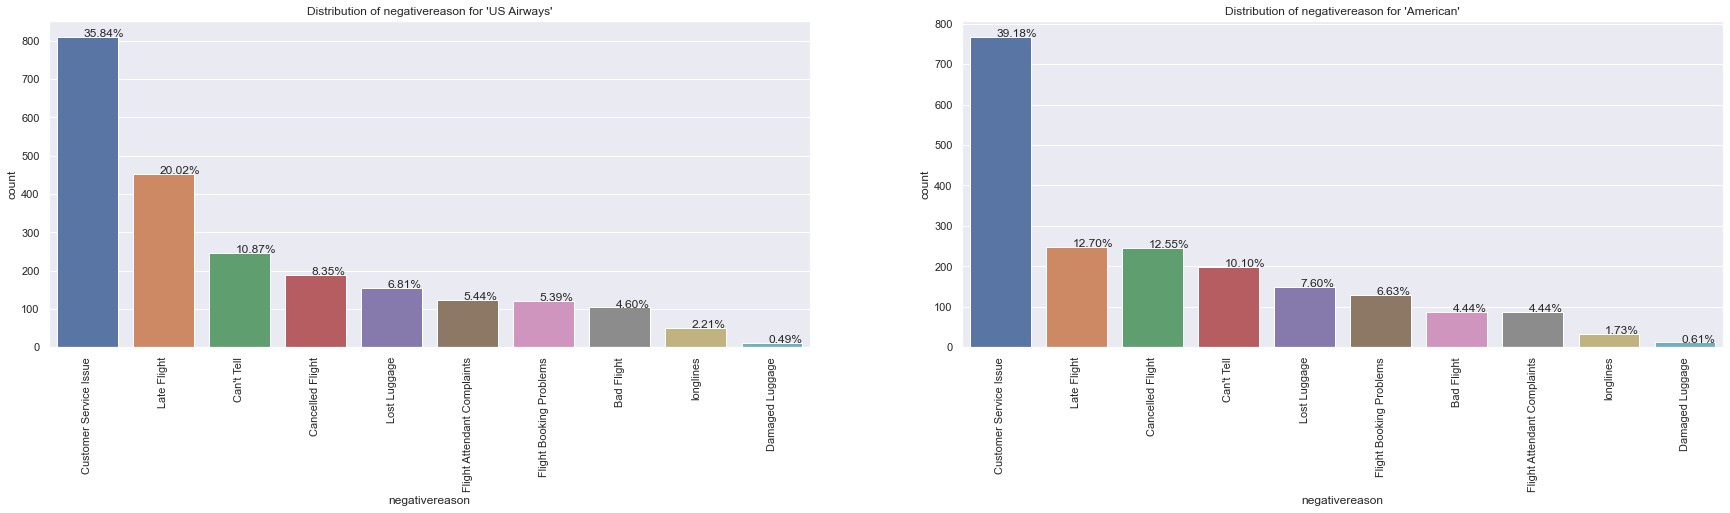

In [15]:
airlines=df.airline.unique()
i=0

# run the loop too total airlines/ 3 times, so that on each row we plot 3 airlines graph

graph_per_row=2

while  i< airlines.size/graph_per_row:
    fig, axes = plt.subplots(ncols=graph_per_row,figsize=(30, 6))
    j=0;
    while j<graph_per_row:
        # create dataframe for each airline
        airline_df=df[df['airline']==airlines[i*graph_per_row+j]]
        
        #plot the distribution of airline_sentiment for a particular airline
        axes[j].set_title("Distribution of negativereason for '"+ airlines[i*graph_per_row+j]+"'")

        for tick in axes[j].get_xticklabels():
            tick.set_rotation(90)
        drawCountPlot('negativereason',axes[j],airline_df) 
        j=j+1
    i=i+1    

**Observation**
* For All Airlines `Customer Service Issue` is the top reason for negative tweets except Delta whose top reason is l;ate flight
* United (10.22%) has highest share for Lost luggage in negative tweets followed by American (7.60%),  Southwest(7.59%) and least share is for 2.76% of Virgin America
* American (39.18%), US Airways (35.84%) and Virgin America (33.15%) of share for negative in customer service issue
* Delta (28.17%), US Airways (20.02%) and United (19.94%) has top 3 share for late flights. American (12.70%) has least share for late flight 

### Word cloud graph of tweets for positive

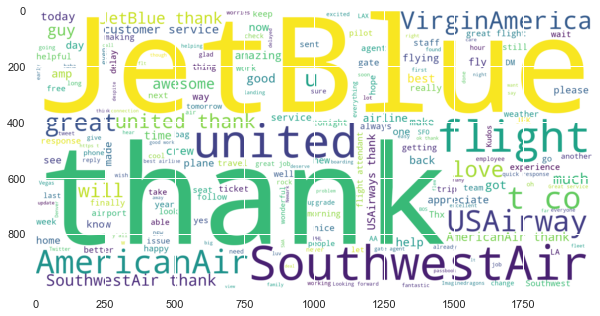

In [16]:
positive=df[df['airline_sentiment']=='positive'].text

word_cloud=worldcloud=WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate("".join(positive))
plt.figure(figsize=(10,10))
plt.imshow(word_cloud,interpolation='bilinear')


**Observation**
* Most common positive words are JetBlue, Thank, SouthwestAirway, Love, Amazing, etc 
* A lot of words appearing is arilines names, since they are tagged in tweets, data prepossing required to remove these words, after that we can rebuild the word cloud

### Word cloud graph of tweets for negative

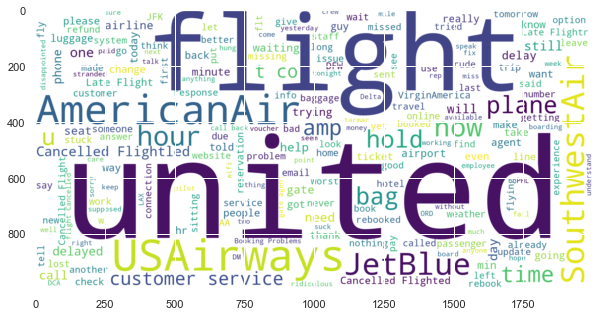

In [17]:
negative=df[df['airline_sentiment']=='negative'].text

word_cloud=worldcloud=WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate("".join(negative))

plt.figure(figsize=(10,10))
plt.imshow(word_cloud,interpolation='bilinear')

**Observation**
* Most common negative words are  United, Flight, USAirways, Hold, Time,, Delay Worst, etc
* A lot of words appearing is arilines names, since they are tagged in tweets, data prepossing required to remove these words, after that we can rebuild the word cloud

### Word cloud graph of tweets for neutral

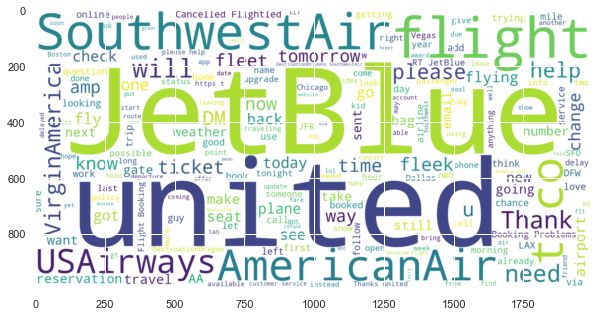

In [18]:
neutral=df[df['airline_sentiment']=='neutral'].text

word_cloud=worldcloud=WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate("".join(neutral))

plt.figure(figsize=(10,10))
plt.imshow(word_cloud,interpolation='bilinear')

**Observation**
* Most commond neutral words are JetBlue, United, Thank, Please, need, tomorrow, Southwest, etc
* A lot of words appearing is arilines names, since they are tagged in tweets, data prepossing required to remove these words, after that we can rebuild the word cloud

## Understanding of Data Columns

 #### Drop all other columns except “text” and “airline_sentiment”

In [19]:
df.drop(['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],axis=1,inplace=True)

#### Shape of the data

In [20]:
print("There are "+ str(df.shape[0]) +" rows and "+ str(df.shape[1])+" columns") 

There are 14640 rows and 2 columns


#### Wiew first 5 rows

In [21]:
df.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


#### Duplicate Row check

In [22]:
df.duplicated().sum()

188

#### Missing value check 

In [23]:
df.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

**Observation**
* There are 188 duplicate records
* There is no missing value

# Data Preprocessing

In [24]:
### Set display.max_colwidth to None, so that column value don't truncate while displaying
pd.set_option('display.max_colwidth', None)

### Useful functions

In [25]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_number(text):
    pattern = r'[0-9]'
    new_text=re.sub(pattern, '', text)
    return new_text

def remove_stopwords(text):
    stopword_list = nltk.corpus.stopwords.words('english')
    stopword_list.remove('no')
    stopword_list.remove('not')
    #Remove stop words from list of tokenized words
    filtered_tokens=[token for token in text if token not in stopword_list]
    return filtered_tokens
  
def to_lowercase(words):
    new_words = []                        
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)       
    return new_words  

def lemmatize_list(words):
    lemmatizer = WordNetLemmatizer()
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word))
    return new_words

def remove_non_ascii(words):
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

def remove_punctuation(words):
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words


def decontracted(phrase):
    # specific & general contracted words
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_username(text):
    return re.sub('@[^\s]+','',text)

def join_words(words):
    return ' '.join(words)

#### Data Type conversion

In [26]:
df["airline_sentiment"] = df["airline_sentiment"].astype("category")
df["text"] = df["text"].astype("string")

### Removing duplicate records

In [27]:
df=df.drop_duplicates()
df.duplicated().sum()

0

### Html tag removal

In [28]:
df.text=df.text.apply(lambda x : strip_html_tags(x))
df.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


### Removal of twitter handle

In [29]:
df.text=df.text.apply(lambda x : remove_username(x))
df.head(5)

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you've added commercials to the experience... tacky.
2,neutral,I didn't today... Must mean I need to take another trip!
3,negative,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it's a really big bad thing about it


### Decontracted

In [30]:
df.text=df.text.apply(lambda x : decontracted(x))
df.head(5)

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


### Remove the numbers

In [31]:
df.text=df.text.apply(lambda x : remove_number(x))
df.head(5)

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


### Tokenization

In [32]:
df.text=df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
df.head(5)

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


### Removal of Special Characters and Punctuations

In [33]:
df.text=df.text.apply(lambda x : remove_non_ascii(x))
df.head(5)

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


In [34]:
df.text=df.text.apply(lambda x : remove_punctuation(x))
df.head(5)

,airline_sentiment,text
0,neutral,"[What, said]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, tacky]"
2,neutral,"[I, did, not, today, Must, mean, I, need, to, take, another, trip]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


### Removal of stopwords

In [35]:
df.text=df.text.apply(lambda x : remove_stopwords(x))
df.head(5)

,airline_sentiment,text
0,neutral,"[What, said]"
1,positive,"[plus, added, commercials, experience, tacky]"
2,neutral,"[I, not, today, Must, mean, I, need, take, another, trip]"
3,negative,"[really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]"
4,negative,"[really, big, bad, thing]"


 ### Conversion to lowercase

In [36]:
df.text=df.text.apply(lambda x : to_lowercase(x))
df.head(5)

,airline_sentiment,text
0,neutral,"[what, said]"
1,positive,"[plus, added, commercials, experience, tacky]"
2,neutral,"[i, not, today, must, mean, i, need, take, another, trip]"
3,negative,"[really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]"
4,negative,"[really, big, bad, thing]"


### Lemmatize or stemming

In [37]:
df.text=df.text.apply(lambda x : lemmatize_list(x))
df.head(5)

,airline_sentiment,text
0,neutral,"[what, said]"
1,positive,"[plus, added, commercial, experience, tacky]"
2,neutral,"[i, not, today, must, mean, i, need, take, another, trip]"
3,negative,"[really, aggressive, blast, obnoxious, entertainment, guest, face, little, recourse]"
4,negative,"[really, big, bad, thing]"


### Join the words in the list to convert back to text string

In [38]:
df.text=df.text.apply(lambda x : join_words(x))
df.head(5)

,airline_sentiment,text
0,neutral,what said
1,positive,plus added commercial experience tacky
2,neutral,i not today must mean i need take another trip
3,negative,really aggressive blast obnoxious entertainment guest face little recourse
4,negative,really big bad thing


## Word Cloud Visualization
### Word cloud graph of tweets for positive

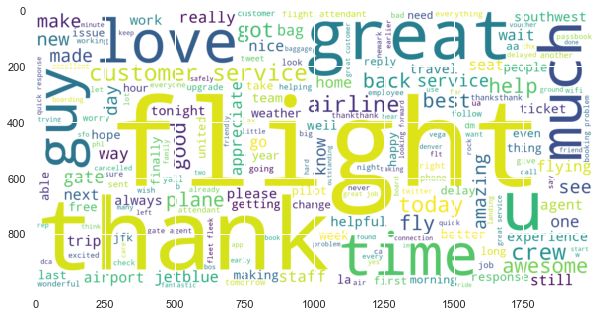

In [39]:
positive=df[df['airline_sentiment']=='positive'].text
word_cloud=worldcloud=WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate("".join(positive))
plt.figure(figsize=(10,10))
plt.imshow(word_cloud,interpolation='bilinear')


**Observation**
* Most common positive words are thank, love, awesome, amazing, great, much, etc

### Word cloud graph of tweets for negative

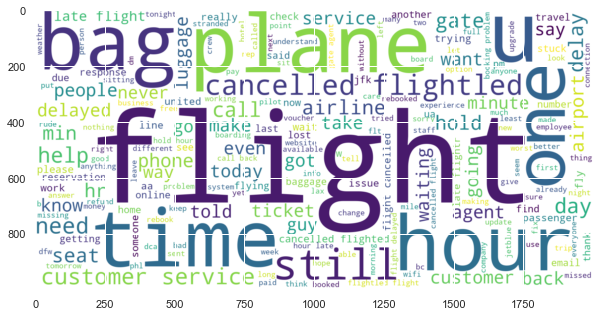

In [40]:
positive=df[df['airline_sentiment']=='negative'].text
word_cloud=worldcloud=WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate("".join(positive))
plt.figure(figsize=(10,10))
plt.imshow(word_cloud,interpolation='bilinear')

**Observation**
* Most common negative words are flight, hour, time, plane, cancelled fligtled, late flight, etc

# Model Building

#### Utility Methods

In [41]:
def plot_confusion_matrix_report(cmatrix,creport):
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # plot confusion matrix 
    plt.figure(figsize=(8,6))
    sns.heatmap(cmatrix, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    plt.show()
    

    
def top40_feature_word_cloud(vectorizer, classifier_mode):
    all_features = vectorizer.get_feature_names()              #Instantiate the feature from the vectorizer
    top_features=''                                            # Addition of top 40 feature into top_feature after training the model
    feat=classifier_mode.feature_importances_
    features=np.argsort(feat)[::-1]
    for i in features[0:40]:
        top_features+=all_features[i]
        top_features+=' '


    from wordcloud import WordCloud
    wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                              height=1000).generate(top_features)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.figure(1, figsize=(10, 6), frameon='equal')
    plt.title('Top 40 features WordCloud', fontsize=20)
    plt.axis("off")
    plt.show()

### X and y variable 

In [42]:
X = df['text']
y = df['airline_sentiment']

## Vectorization

### TfidfVectorizer

In [43]:
# Vectorization (Convert text data to numbers).
tfidfVectorizer = TfidfVectorizer()
fidfv_data_features = tfidfVectorizer.fit_transform(X)
fidfv_data_features = fidfv_data_features.toarray()
fidfv_data_features.shape

(14452, 12152)

#### Split the data into train and test

In [44]:
X_train, X_test, y_train, y_test = train_test_split(fidfv_data_features, y, test_size=0.3, random_state=3)
print(X_train.shape, X_test.shape)

(10116, 12152) (4336, 12152)


In [45]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 10116
Number of rows in test data = 4336


#### RandomForestClassifier

In [46]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=3)
rf_estimator.fit(X_train,y_train)
random_forest_classifier_prediction =  rf_estimator.predict(X_test)

##### Random Forest Classifier accuracy

In [47]:
accuracy_score(random_forest_classifier_prediction,y_test)

0.7693726937269373

##### Random Forest Classification Report

In [48]:
cr = classification_report(y_test, random_forest_classifier_prediction)
cm = confusion_matrix(y_test,random_forest_classifier_prediction)

Classification Report
--------------------
              precision    recall  f1-score   support

    negative       0.79      0.94      0.86      2737
     neutral       0.63      0.46      0.53       896
    positive       0.80      0.51      0.62       703

    accuracy                           0.77      4336
   macro avg       0.74      0.64      0.67      4336
weighted avg       0.76      0.77      0.75      4336



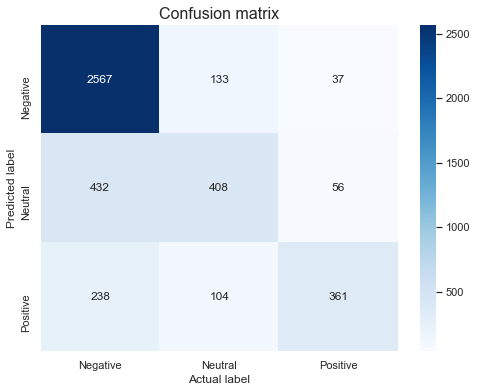

In [49]:
print("Classification Report")
print("--------------------")
print(cr)
plot_confusion_matrix_report(cm,cr)

#### Top 40 Feature Word Cloud

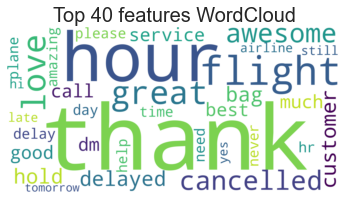

In [50]:
top40_feature_word_cloud(tfidfVectorizer,rf_estimator)

### CountVectorizer

In [51]:
# Vectorization (Convert text data to numbers).
vectorizer = CountVectorizer()
countv_data_features = vectorizer.fit_transform(X)
countv_data_features = countv_data_features.toarray() 
countv_data_features.shape

(14452, 12152)

#### Split the data into train and test

In [52]:
X_train, X_test, y_train, y_test = train_test_split(countv_data_features, y, test_size=0.3, random_state=3)
print(X_train.shape, X_test.shape)

(10116, 12152) (4336, 12152)


In [53]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 10116
Number of rows in test data = 4336


#### RandomForestClassifier

In [54]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=3)
rf_estimator.fit(X_train,y_train)
random_forest_classifier_prediction =  rf_estimator.predict(X_test)

##### Random Forest Classifier accuracy

In [55]:
accuracy_score(random_forest_classifier_prediction,y_test)

0.7691420664206642

##### Random Forest Classification Report

In [56]:
cr = classification_report(y_test, random_forest_classifier_prediction)
cm = confusion_matrix(y_test,random_forest_classifier_prediction)

Classification Report
--------------------
              precision    recall  f1-score   support

    negative       0.81      0.91      0.86      2737
     neutral       0.60      0.50      0.55       896
    positive       0.76      0.55      0.64       703

    accuracy                           0.77      4336
   macro avg       0.72      0.66      0.68      4336
weighted avg       0.76      0.77      0.76      4336



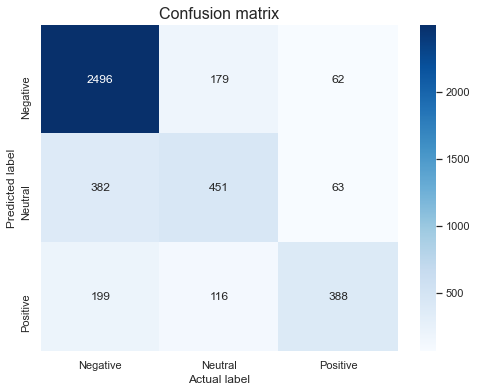

In [57]:
print("Classification Report")
print("--------------------")
print(cr)
plot_confusion_matrix_report(cm,cr)

#### Top 40 Feature Word Cloud

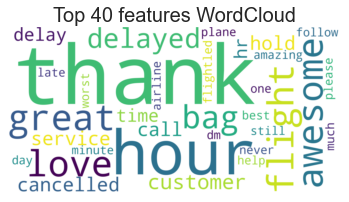

In [58]:
top40_feature_word_cloud(vectorizer,rf_estimator)

**Observation**
* TfidfVectorizer has an accuracy of 0.76937% and CountVectorizer has an accuracy of 0.769142% on test data
* Most important features are Thank, hour , cancelled, flight, awesome, great, love, hold, delay, etc

### Improving model performance with TfidfVectorizer

In [59]:
X = df['text']
y = df['airline_sentiment']

#### Application of TfidfVectorizer

In [60]:
tfidf_vectorizer = TfidfVectorizer()
X =  tfidf_vectorizer.fit_transform(X)

#### Handling of Imbalance data using SMOTE

In [61]:
smote = SMOTE()
Y_smote,y_smote = smote.fit_resample(X,y)

#### Splitting dataset into train and test

In [62]:
X_train, X_test, y_train, y_test = train_test_split(Y_smote, y_smote, test_size=0.3, random_state=3)
print(X_train.shape, X_test.shape)

(19082, 12152) (8179, 12152)


In [63]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 19082
Number of rows in test data = 8179


#### RandomForestClassifier

In [64]:
rf_estimator = RandomForestClassifier(random_state=3)
rf_estimator.fit(X_train,y_train)
random_forest_classifier_prediction =  rf_estimator.predict(X_test)

In [65]:
#Fitting the model
random_forest_classifier_prediction =  rf_estimator.predict(X_test)

##### Random Forest Classifier accuracy

In [66]:
accuracy_score(random_forest_classifier_prediction,y_test)

0.8792028365325835

##### Random Forest Classification Report

Classification Report
--------------------
              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      2759
     neutral       0.84      0.87      0.85      2694
    positive       0.92      0.91      0.92      2726

    accuracy                           0.88      8179
   macro avg       0.88      0.88      0.88      8179
weighted avg       0.88      0.88      0.88      8179



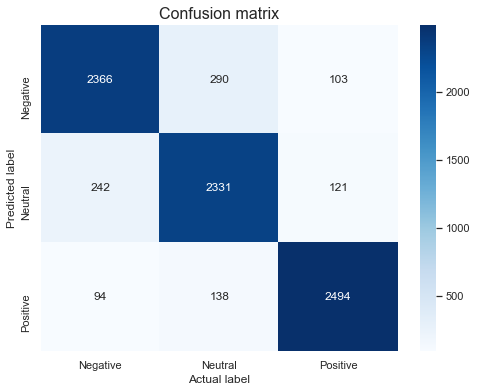

In [67]:
cr = classification_report(y_test, random_forest_classifier_prediction)
cm = confusion_matrix(y_test,random_forest_classifier_prediction)
print("Classification Report")
print("--------------------")
print(cr)
plot_confusion_matrix_report(cm,cr)

#### Top 40 Feature Word Cloud

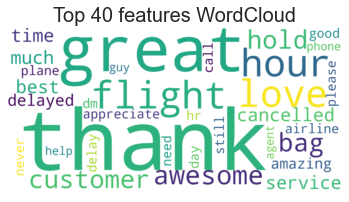

In [68]:
top40_feature_word_cloud(vectorizer,rf_estimator)

# Conclusion

#### EDA - Tweets Categorization
* Given tweets dataset has 14640 rows with 15 columns and there are 36 duplicate rows
* Entire tweets is classified into three sentiments.
    * 62.69% of tweets were negative in nature
    * 21.17% of tweets were neutral nature
    * 16.14% were positive in nature
* Maximum number of tweets were for 
  * United (26.11%)
  * US Airways(19.90%)
  * American (18.85%)
  * Virgin America has the least number of tweets (ie. only 3.44%)
  
* Negative tweets
  * US Airways has the maximum percentage of negative tweets (77.69%) out of their total tweets. Followed by 
  * American (71.04)
  * United (68.89%)
* Virgin America has well balanced negative, positve and neutral tweets as compared to other airlines.

* One of the main reason for negative tweets in Customer Service Issue. This reason occupies 31.71% of negative tweets. Followed by Late Flight.
* All airlines has Customer Serivce Issue as the main reason for negative tweets except Delta which has Late Flight as the top reason for negative tweets.
* In terms of Late Flight (Negative tweets reason)
    * Delta has 28.17% tweets followed by 
    * US Airways (20.02%) and 
    * United (19.94%).
    
    
    
#### Data Preprocessing
* For data preprocessing we applied
    * Removal of Html tag
        * HTML tags are typically one of these section which don’t add much value towards understanding and analyzing text
    * Removal of twitter handle
        * Tweets contains lots of twitter handle - which results in unnecessary procesing of these words also it influences most important features of the model. Hence these needs to be removed.
    * Decontraction
        * Decontraction helps to covert back short form of word like can't to can not. Spo that it can be analyzed better way
    * Removal of numbers
        * We usually remove numbers when we do text clustering or getting keyphrases as we numbers doesn’t give much importance to get the main words
    * Tokenization
        * As tokens are the unit blocks of Natural Language, the most common way of processing the raw text happens at the token level
    * Removal of special characters and punctuations \
        * Special characters and symbols are usually non-alphanumeric characters which adds to the extra noise in unstructured text
    * Removal of stopwords
        * Stopwords are common words that carry less important  meaning than keywords. When using some bag of words based methods, i.e.,  countVectorizer or tfidf that works on counts and  frequency of the words, removing stopwords is great as  it lowers the dimensional space
    * Converted text to lowercase before lemmatization
        * Lemmatization involves resolving words to their dictionary form. A lemma of a word is its dictionary or canonical form. Lemmatization returns an actual word of the language, it is used where it is vital to get valid words
    
    
#### Data Model and Its performance
* TfidfVectorizer has an accuracy of 0.76937% and CountVectorizer has an accuracy of 0.769142% on test data with RandomForestClassifier.
* Accuracy of the model is increased when we applied SMOTE for handling unbalanced data. We found accuracy 0.8756% on test data for RandomForestClassifier with TfidfVectorizer.
* Thank, Great, Cancelled, Awesome, flight, amazing, delayed, worst, etc are top feature words for the model